# GMS Contract Childhood Vaccine Calculations

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
rawdf=pd.read_csv('~/gpcontract/2019/England/Childhood Imms/child_imms_gp_data_1819.csv')

This is the [data file published by NHS Digital](https://digital.nhs.uk/data-and-information/publications/statistical/childhood-immunisation-ccg-gp-practice-level-coverage-statistics/childhood-immunisation-ccg-gp-practice-level-coverage-statistics---2018-19/childhood-immunisation-statistics-ccg-gp-practice-level-coverage-2018-19-m.i). The latest published data at the time of writing was for 2018/19. This is nearly two years out of date but the programme has not changed a lot since then. What may have changed is practice sizes etc. as well as some levels of achievement. This is all annual data as well rather than the quarterly figures.

In [3]:
rawdf.Value.replace([-1.0,-2.0],np.nan,inplace=True) #There are some placeholders for suppressed data etc. Replace these with NaN
rawdf.reset_index(inplace=True)
currentData=rawdf[rawdf.OrgCodeStatus=="Current"] #Only active practices
noDupes=currentData.drop_duplicates(['OrgCode','VacCode']) #There are some duplicate summary rows. This gets rid of them
pivoted=noDupes.pivot("OrgCode","VacCode","Value") #A nice format to work with

In [4]:
pivoted.describe()

VacCode,Cohort_12m,Cohort_24m,Cohort_5y,DTaP_IPV_5y,DTaP_IPV_Hib_12m,DTaP_IPV_Hib_24m,DTaP_IPV_Hib_5y,Hib_MenC_24m,Hib_MenC_5y,MMR1_24m,MMR1_5y,MMR2_5y,MenB_12m,PCV_12m,PCV_24m,Rota_12m
count,6927.000000,6929.000000,6926.000000,6924.000000,6925.000000,6925.000000,6924.000000,6925.000000,6924.000000,6925.000000,6924.000000,6924.000000,6925.000000,6925.000000,6925.000000,6925.000000
mean,91.903277,94.491269,97.725094,83.856376,91.811104,94.302445,94.460959,90.464841,92.153335,90.261435,94.336373,86.649556,91.930112,92.313954,90.131218,90.078929
std,62.376509,63.461029,65.496139,16.140070,7.843727,5.912950,7.424271,8.357969,7.739153,8.273257,6.161383,10.709857,7.712595,7.810344,8.712866,7.925149
min,0.000000,0.000000,0.000000,0.000000,7.894737,16.666667,0.000000,0.000000,12.500000,0.000000,12.500000,0.000000,7.894737,7.894737,0.000000,7.894737
25%,49.000000,50.000000,52.000000,80.000000,89.423077,92.550790,93.162393,87.142857,89.830508,86.956522,92.546093,82.571353,89.610390,90.184049,86.842105,87.096774
50%,79.000000,81.000000,84.000000,88.235294,93.548387,95.652174,96.385542,92.592593,94.082840,92.258065,95.890411,89.430894,93.750000,94.117647,92.417062,91.666667
75%,120.000000,123.000000,127.000000,93.103448,96.551724,97.872340,98.362883,96.000000,96.835443,95.705522,98.019802,93.711590,96.666667,96.913580,95.833333,95.092024
max,839.000000,815.000000,898.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


## Create Some Calculators
### Notes on the Two Year Old Calculators
There are calculations to be done. This is based on the SFE - explained in the [full version on page 43](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/233366/gen_med_servs_statement_financial_entitlements_directions_2013_acc.pdf).
The [current schedule](https://www.gov.uk/government/publications/routine-childhood-immunisation-schedule) lists the six injections. Rotavirus was paid separately and I have not included it here. The two year old target also included MMR and HiB/MenC vaccinations at just over a year old. For this reason the individual schemes are not completely comparable and so we will have to look at childhood vaccinations as a whole.
There quite a few assumptions in these calculations. These were previously calculated quarterly so they could vary through the year. As we only have annual figures then we will use this. This can make quite big changes to practice figures.
For some reason the typical cohort size is rather smaller in the old calculation than the new one. 
The PCV_MenC is paid for a complete course. As we only have the individual figures I have taken the minimum as the closest we have to the number of complete courses.
For the new calculation I have assumed that the 80% threshold applies to each vaccination course individually. I have also assumed that each course has a cohort size of one year group. It is not really clear what the denominator is here. There was a proper mechnism promised in the [details for 2020/21](https://www.england.nhs.uk/publication/investment-and-evolution-update-to-the-gp-contract-agreement-20-21-23-24/) but this did not actually appear when the SFE amendments were issued.
The limitations are:
* Using annual rather than quarterly data will be an approximation only for the old target thresholds
* Where there are multiple vaccinations in one course I have used the minimum achievement for any of the vaccines. That is likely a small overestimate
* Some assumptions about how the 80% threshold will work.
* The QOF point value is for 2020/21 but the cohorts are for 2019. This is likely to artificially increase the value value by a few percent.

### A note on the MMR item of service payment
This was brought in in 2020/21. Depending on your point of view this was the first of the new arrangements or the last of the old. The scale of the increase will look different depending on your base year. It is easy to comment out that line if you want to use 2019/20 as the old comparison or leave it in for 2020/21 as the old.

In [5]:
def Two_old(cohort,DTP,MMR,MenC,MenB,PCV_MenC,Rota):
    achievement=(DTP*2+MMR+MenC)/4
    typical=63 #this is from the SFE
    lower_payment=538.08
    higher_payment=1614.24
    if achievement>=90:
        actual_payment=higher_payment
    elif achievement>=70:
        actual_payment=lower_payment
    else:
        actual_payment=0
    actual_payment= 4*actual_payment*cohort/typical #multiply by four to annualise it
    actual_payment+= MenB*10.06*cohort*2/100 # two MenB vaccinations (although the data is for 12m)
    actual_payment+= PCV_MenC*15.02*cohort/100 # two PCV and one MenC
    actual_payment+= Rota*10.06*cohort/100 #There are two but only one is paid
    #actual_payment+= ios(cohort,MMR) #This only applies to 2020/21
    return actual_payment

def calcQOF(achievement,lower,upper,minpoints,totpoints): #calculate earned points against achievement
    if achievement <= lower:
        points_achieved=0
    elif achievement >= upper:
        points_achieved=totpoints
    else:
        points_achieved= minpoints+totpoints*(achievement-lower)/(upper-lower)
    return points_achieved

def ios(cohort,achievement):
    ios=10.06
    if achievement<50 :
        achievement=0
    elif achievement<80 :
        achievement=achievement-50
    return cohort*achievement*ios/100
        
def Two_new(cohort,DTP,MMR,MenC,MenB,PCV,Rota):
    typical=91 #based on the 2019 dataset
    QOFvalue=201.16 #needs to be updated
    DTP_vaccinations=3 #there are currently six injections up to 16 weeks in the schedule. Rotavirus was in IoS before

    points_DTP=calcQOF(DTP,90,95,3,18) 
    points_MMR=calcQOF(MMR,90,95,7,18) 

    QOF_payment=(points_DTP+points_MMR)*QOFvalue*cohort/typical #QOF points with prevalence adjustment
    ios_payment=ios(cohort,DTP)*DTP_vaccinations #the item of service payment for the vaccinations
    ios_payment+=ios(cohort,MenB)*2
    ios_payment+=ios(cohort,PCV)*2
    ios_payment+=ios(cohort,Rota)*2
    ios_payment+=ios(cohort,MMR) 
    ios_payment+=ios(cohort,MenC)
    return QOF_payment+ios_payment

## Five Year Old Vaccination Calculators
Same sort of thing for the five year old vaccinations. This is much simpler to calculate than the two year olds as there are only two vaccinations on the national schedule, the DTaP and MMR boosters. The formulae are basically the same as before so we can reuse the functions.
Again the MMR IOS appeared in 2020/21 so if you are commenting it out in the two year old formulae you can comment it out here.

In [6]:
def Five_old(cohort,DTP,MMR):
    achievement=(DTP+MMR)/2
    typical=58 #this is from the SFE
    lower_payment=223.82
    higher_payment=671.48
    if achievement>=90:
        actual_payment=higher_payment
    elif achievement>=70:
        actual_payment=lower_payment
    else:
        actual_payment=0
    actual_payment= 4*actual_payment*cohort/typical #multiply by four to annualise it
    #actual_payment+=ios(cohort,MMR)  #there was an IOS payment in 2020/21
    return actual_payment

def Five_new(cohort,DTP,MMR):
    typical=97 #Based on the five year old cohort mean
    QOFvalue=201.16
    points=calcQOF(min([MMR,DTP]),87,95,7,18) #We assume that the minimum is the same as the overall achivement
    ios_payment=ios(cohort,DTP)
    ios_payment+=ios(cohort,MMR)
    QOF_payment=points*QOFvalue*cohort/typical
    return ios_payment+QOF_payment

    

## Apply the Calculators

The calculations are applied here. We use DTAP at 24 months for the old calculations as they were based at 2 years old and 12m for the new as they are calculated at eight months and this is closest that we can get. We could do the same with the cohorts but some of the calculations are at 8 months and some at 18 months (MMR). This could be broken down further but this is probably within the margin of error of the calculations anyway.

In [7]:
payments={}
for index,row in pivoted.iterrows():
    payments[index]={ \
                     "5yo_old":Five_old(row['Cohort_5y'],row['DTaP_IPV_5y'],row['MMR2_5y']), \
                     "5yo_new":Five_new(row['Cohort_5y'],row['DTaP_IPV_5y'],row['MMR2_5y']), \
                     "2yo_old":Two_old(row['Cohort_24m'],row['DTaP_IPV_Hib_24m'],row['MMR1_24m'],row['Hib_MenC_24m'],row['MenB_12m'],min([row['PCV_24m'],row['PCV_12m'],row['Hib_MenC_24m']]),row['Rota_12m']), \
                     "2yo_new":Two_new(row['Cohort_24m'],row['DTaP_IPV_Hib_12m'],row['MMR1_24m'],row['Hib_MenC_24m'],row['MenB_12m'],row['PCV_12m'],row['Rota_12m']) \
                    }
payframe=pd.DataFrame(payments).T #Into a dataframe, "T" makes it the right way around
payframe.describe()
print("Total paid under the old system is £","{:,}".format(payframe["5yo_old"].sum()+payframe["2yo_old"].sum()))
print("Total paid under the new system is £","{:,}".format(payframe["5yo_new"].sum()+payframe["2yo_new"].sum()))

Total paid under the old system is £ 100,813,709.54679939
Total paid under the new system is £ 118,293,368.29479364


In [8]:
payframe['increase']=(payframe['2yo_new']+payframe['5yo_new'])/(payframe['2yo_old']+payframe['5yo_old'])
print("Practices who would have less under the new system",(payframe.increase<1).value_counts()[True])
print("Practices who would have more than ten percent increase",(payframe.increase>1.1).value_counts()[True])
print("Practices who would have more than twenty percent increase",(payframe.increase>1.2).value_counts()[True])
payframe.describe()

Practices who would have less under the new system 1376
Practices who would have more than ten percent increase 4759
Practices who would have more than twenty percent increase 3735


,5yo_old,5yo_new,2yo_old,2yo_new,increase
count,6926.000000,6924.000000,6898.000000,6898.000000,6875.000000
mean,2660.768627,3224.692098,11943.349671,13912.090492,1.172562
std,2563.351464,3251.420926,8749.976632,10290.001940,0.270275
min,0.000000,0.000000,83.234286,0.000000,0.000000
25%,972.459310,824.920000,5785.723949,6629.435147,1.044146
50%,1944.918621,2233.320000,9888.783815,11519.855363,1.218019
75%,3654.440345,4697.515100,15968.627738,18758.621421,1.291301
max,28896.794483,32875.946435,109733.933978,97010.447050,3.608965


<AxesSubplot:>

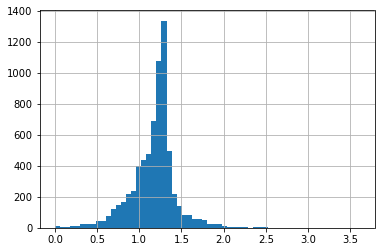

In [9]:
payframe['increase']=(payframe['5yo_new']+payframe['2yo_new'])/(payframe['5yo_old']+payframe['2yo_old'])
payframe['increase'].hist(bins=60)


# Pick Some Practices To Compare
These were entirely by eyeballing practices with cohort of 70 at 12m just to give some comparison. It is difficult to pick winners and losers overall as you can see in the chart at the end of the notebook.

In [10]:
pivoted.loc[["G85681","C81074","P92006"]]

VacCode,Cohort_12m,Cohort_24m,Cohort_5y,DTaP_IPV_5y,DTaP_IPV_Hib_12m,DTaP_IPV_Hib_24m,DTaP_IPV_Hib_5y,Hib_MenC_24m,Hib_MenC_5y,MMR1_24m,MMR1_5y,MMR2_5y,MenB_12m,PCV_12m,PCV_24m,Rota_12m
OrgCode,,,,,,,,,,,,,,,,
G85681,70.0,61.0,63.0,49.206349,75.714286,86.885246,76.190476,68.852459,74.603175,70.491803,77.777778,68.253968,75.714286,77.142857,67.213115,74.285714
C81074,70.0,73.0,73.0,87.671233,94.285714,91.780822,95.890411,90.410959,89.041096,90.410959,94.520548,84.931507,95.714286,95.714286,90.410959,95.714286
P92006,70.0,46.0,73.0,94.520548,97.142857,100.000000,98.630137,97.826087,98.630137,97.826087,98.630137,94.520548,97.142857,97.142857,97.826087,94.285714


In [11]:
payframe.loc[["G85681","C81074","P92006"]]

,5yo_old,5yo_new,2yo_old,2yo_new,increase
G85681,0.000000,115.690000,4084.930667,1661.624571,0.435091
C81074,1126.817931,1267.560000,10581.914000,11964.756426,1.130124
P92006,3380.554483,5009.678438,6721.178285,8585.471032,1.345824


# Old V New
A very rough comparison is to look at the payment per patient under the old system and then the new. The line up the middle of this chart is actually the line of best fit rather than line of no change but it is clear that there is a wide range of values.
The vertical lines in this chart are caused, I think, by practices clustering around the payments from the thresholds under the old system. As you were paid a certain amount at 70% and another amount at 90% and no different around there then practices tend to cluster.

<AxesSubplot:xlabel='old_pp', ylabel='new_pp'>

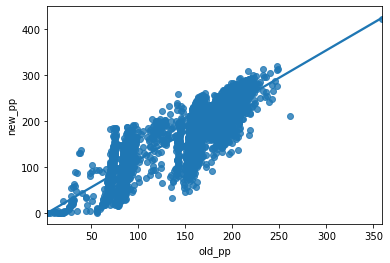

In [12]:
payframe['old_pp']=(payframe['5yo_old']+payframe['2yo_old'])/pivoted['Cohort_24m']
payframe['new_pp']=(payframe['5yo_new']+payframe['2yo_new'])/pivoted['Cohort_24m']

sns.regplot(x='old_pp',y='new_pp',data=payframe)